<a href="https://colab.research.google.com/github/qjy9ey/pca_assignment/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [2]:
import pickle
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

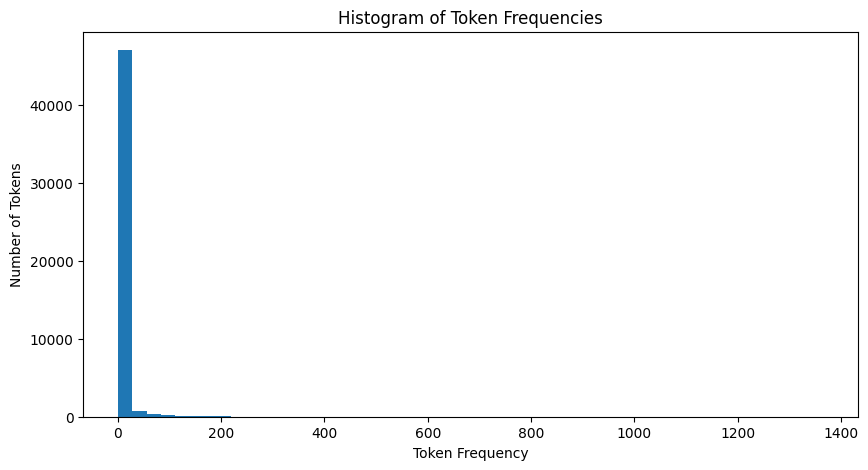

In [12]:
import matplotlib.pyplot as plt

# extract the frequencies from the token_freq list
frequencies = [freq for token, freq in token_freq]

# plot histogram (linear scale)
plt.figure(figsize = (10, 5))
plt.hist(frequencies, bins = 50)
plt.title("Histogram of Token Frequencies")
plt.xlabel("Token Frequency")
plt.ylabel("Number of Tokens")
plt.show()

The histogram shows a highly right-skewed distribution: a small number of tokens appear very frequently, while most appear rarely.

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df = pd.read_parquet("Phishing_clean.parquet")
df.to_csv("Phishing_clean.csv", index=False)
df = pd.read_csv("Phishing_clean.csv")

# separate target and features
y = df["Email Type"]
X = df.drop(columns=["Email Type"])

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit regression model
model = LinearRegression()
model.fit(X_train, y_train)

# predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# compute R^2
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# find most influential words
coef = pd.Series(model.coef_, index=X.columns)
top_influential = coef.abs().sort_values(ascending=False).head(10)
top_influential_words = coef.loc[top_influential.index]

print("R² (train):", r2_train)
print("R² (test):", r2_test)
print("\nTop 10 most influential words:")
print(top_influential_words)

R² (train): 0.7670143724934355
R² (test): 0.6658718438847919

Top 10 most influential words:
intervention        -1.259257
localized            0.824350
thermal              0.747006
crawler              0.696167
background-image:   -0.622909
helvetica,           0.598560
aging                0.594956
form.                0.576886
gray;               -0.574480
a:active             0.574480
dtype: float64


### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

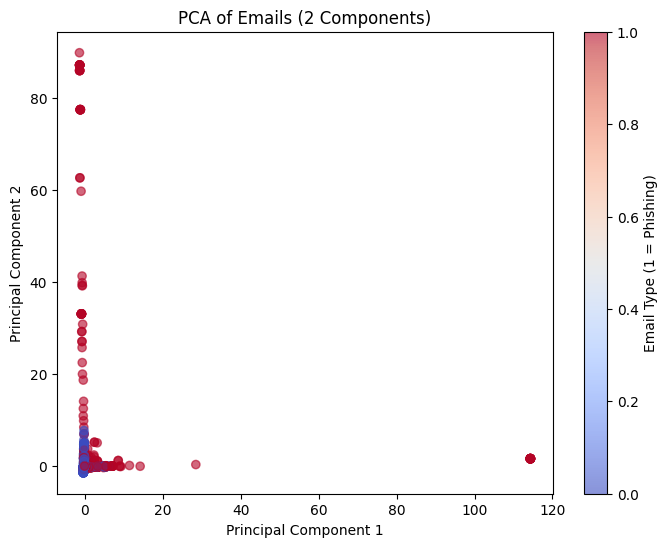

In [14]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# load data
df = pd.read_csv("Phishing_clean.csv")

# separate features and target
y = df["Email Type"]
X = df.drop(columns = ["Email Type"])

# standardize features
scaler = StandardScaler(with_mean = False)
X_scaled = scaler.fit_transform(X)

# perform PCA with 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# create PCA DataFrame
pca_df = pd.DataFrame(data = X_pca, columns = ["PC1", "PC2"])
pca_df["Email Type"] = y

# plot
plt.figure(figsize = (8, 6))
plt.scatter(
    pca_df["PC1"], pca_df["PC2"],
    c=pca_df["Email Type"], cmap = "coolwarm", alpha = 0.6)
plt.title("PCA of Emails (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label = "Email Type (1 = Phishing)")
plt.show()


There is a lot of clustering, where phishing emails (1) and non-phishing emails (0) occupy slightly different regions. Phishing emails form tighter clusters if they share distinctive vocabulary (e.g., "account", "verify", "click", "password").

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.